In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import nibabel as nib
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image 
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [2]:
import os
data = pd.read_csv("./new4_filtered_BRCA1_or_2_subtype_bc_0or1.csv", encoding='ascii')
print(data.head())


                              Image_Path  Tumor_Label  ER  PR  Final_HER2  \
0  ./dataset/290/MRI_total/axial0026.png            0   1   1           0   
1  ./dataset/290/MRI_total/axial0022.png            1   1   1           0   
2  ./dataset/290/MRI_total/axial0001.png            0   1   1           0   
3  ./dataset/290/MRI_total/axial0034.png            0   1   1           0   
4  ./dataset/290/MRI_total/axial0015.png            0   1   1           0   

   BRCA1_or_2  Ki_67  
0           1      2  
1           1      2  
2           1      2  
3           1      2  
4           1      2  


In [3]:
class MRIDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data.iloc[idx, 0])
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found at path: {img_path}")
        
        image = Image.open(img_path)
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label



In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16,
                 emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'))
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions

        return x

PE = PatchEmbedding()
summary(PE, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


x = torch.randn(8, 3, 224, 224)
PE = PatchEmbedding()
x = PE(x)
print(x.shape)
MHA = MultiHeadAttention()
summary(MHA, x.shape[1:], device='cpu')

torch.Size([8, 197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 197, 2304]       1,771,776
           Dropout-2          [-1, 8, 197, 197]               0
            Linear-3             [-1, 197, 768]         590,592
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.58
Forward/backward pass size (MB): 6.99
Params size (MB): 9.01
Estimated Total Size (MB): 16.57
----------------------------------------------------------------


In [7]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

x = torch.randn(8, 3, 224, 224)
x = PE(x)
x = MHA(x)
TE = TransformerEncoderBlock()
summary(TE, x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 197, 768]           1,536
            Linear-2            [-1, 197, 2304]       1,771,776
           Dropout-3          [-1, 8, 197, 197]               0
            Linear-4             [-1, 197, 768]         590,592
MultiHeadAttention-5             [-1, 197, 768]               0
           Dropout-6             [-1, 197, 768]               0
       ResidualAdd-7             [-1, 197, 768]               0
         LayerNorm-8             [-1, 197, 768]           1,536
            Linear-9            [-1, 197, 3072]       2,362,368
             GELU-10            [-1, 197, 3072]               0
          Dropout-11            [-1, 197, 3072]               0
           Linear-12             [-1, 197, 768]       2,360,064
          Dropout-13             [-1, 197, 768]               0
      ResidualAdd-14             [-1, 1

In [8]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

# Model : Vision Transformer(ViT)
## Epoch : 100

True
13381
2677
10704


Epoch 1/100
Train Loss: 0.5885866536271005, Train Accuracy: 82.45515695067265
Validation Loss: 0.44055932192575364, Validation Accuracy: 84.27344041837878
--------------------------------------------------
Epoch 2/100
Train Loss: 0.4370914300282796, Train Accuracy: 83.09043348281017
Validation Loss: 0.4209563490890321, Validation Accuracy: 84.27344041837878
--------------------------------------------------
Epoch 3/100
Train Loss: 0.4246804964329515, Train Accuracy: 82.92227204783259
Validation Loss: 0.3796710116522653, Validation Accuracy: 84.23608516996639
--------------------------------------------------
Epoch 4/100
Train Loss: 0.4049662055359, Train Accuracy: 82.94095665171898
Validation Loss: 0.382509457213538, Validation Accuracy: 84.23608516996639
--------------------------------------------------
Epoch 5/100
Train Loss: 0.3976714208367325, Train Accuracy: 82.94095665171898
Validation Loss: 0.38910394942476634, Validation Accuracy: 84.31079566679118
----------------------------

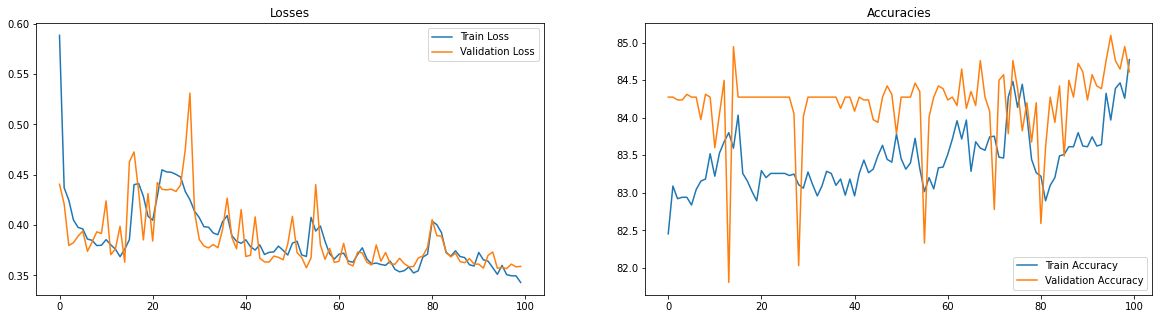

Total Training Time: 08:12:51.22


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import time

start_time = time.time()
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset_bc_0or1 = MRIDataset("./BRCA1_or_2_subtype_bc_0or1.csv", transform=transform)

dataset_length = len(dataset_bc_0or1)
train_size = int(0.8 * dataset_length)
val_size = dataset_length - train_size
print(train_size + val_size == len(dataset_bc_0or1))
print(len(dataset_bc_0or1))
print(val_size)
print(train_size)
train_dataset, val_dataset = random_split(dataset_bc_0or1, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
model = ViT(in_channels=1, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.85, 0.999), eps=1e-07)

num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss/len(train_loader))

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}")
    print(f"Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}")
    print("-"*50)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')
plt.show()
torch.save(model.state_dict(), 'new4_8_2_model_bc_0or1_ViT_epoch100_1128.pth')

elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total Training Time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))